In [1]:
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 KB 821.4 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=370073 sha256=1054ba707572d87fbd179218f2c6543aaa366b8263deb41d29484ac910ca3d6b
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built pycocotools


In [16]:
import numpy as np
import pandas as pd
import os
import sys
import json
import matplotlib.pyplot as plt
import tifffile
import glob
import seaborn as sns
import cv2
from pycocotools import mask as coco_mask
import skimage
from tqdm import tqdm
import time

In [3]:
SHSY5Y_LIVECELL_TRAIN_IMAGE_FOLDER = '../input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/images/livecell_train_val_images/SHSY5Y'
SHSY5Y_LIVECELL_TRAIN_ANNOTATION_PATH = '../input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/shsy5y/livecell_shsy5y_train.json'
SHSY5Y_LIVECELL_VAL_ANNOTATION_PATH = '../input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/shsy5y/livecell_shsy5y_val.json'

In [4]:
f = open(SHSY5Y_LIVECELL_TRAIN_ANNOTATION_PATH)
annotation = json.load(f)

In [5]:
annotation.keys()

dict_keys(['images', 'annotations', 'categories', 'info', 'licenses'])

In [6]:
print('Number of images: ', len(annotation['images']))

Number of images:  449


Creating annotation DataFrame

In [7]:
annotation_df = pd.DataFrame(annotation['annotations']).transpose()
image_df = pd.DataFrame(annotation['images'])

In [8]:
annotation_df.head()

,segmentation,area,iscrowd,image_id,bbox,category_id,id
1564018,"[[431.64, 126.36, 439.47, 131.9, 439.08, 136.4...",300.0471,0,1564017,"[427.25, 126.36, 18.899999999999977, 42.769999...",1,1564018
1564019,"[[279.35, 263.81, 282.28, 264.54, 284.72, 265....",223.89695,0,1564017,"[253.26, 263.1, 38.79000000000002, 9.389999999...",1,1564019
1564020,"[[291.16, 262.34, 298.03, 262.8, 299.86, 260.8...",129.8141,0,1564017,"[282.32, 260.36, 22.889999999999986, 14.610000...",1,1564020
1564021,"[[278.04, 241.57, 288.86, 242.69, 294.08, 238....",333.7615,0,1564017,"[277.3, 234.48, 39.90999999999997, 20.14000000...",1,1564021
1564022,"[[182.24, 30.73, 187.01, 19.99, 184.33, 13.43,...",234.7215,0,1564017,"[170.17, 0.0, 16.840000000000003, 30.9]",1,1564022


In [9]:
image_df.head()

,url,file_name,height,width,original_filename,id
0,https://darwin.v7labs.com/api/images/37815/ori...,SHSY5Y_Phase_C10_2_00d04h00m_3.tif,520,704,SHSY5Y_Phase_C10_2_00d04h00m_3.png,1564017
1,https://darwin.v7labs.com/api/images/108474/or...,SHSY5Y_Phase_B10_1_03d12h00m_2.tif,520,704,SHSY5Y_Phase_B10_1_03d12h00m_2.png,1420519
2,https://darwin.v7labs.com/api/images/922455/or...,SHSY5Y_Phase_D10_1_00d00h00m_4.tif,520,704,SHSY5Y_Phase_D10_1_00d00h00m_4.png,1419396
3,https://darwin.v7labs.com/api/images/47611/ori...,SHSY5Y_Phase_B10_2_01d12h00m_1.tif,520,704,SHSY5Y_Phase_B10_2_01d12h00m_1.png,1498293
4,https://darwin.v7labs.com/api/images/47647/ori...,SHSY5Y_Phase_D10_1_02d08h00m_1.tif,520,704,SHSY5Y_Phase_D10_1_02d08h00m_1.png,1439054


Check unique images in annotation_df are equal number of shsy5y images

In [10]:
assert annotation_df['image_id'].nunique() == len(image_df)

Count instances per image

In [11]:
ins_per_img = annotation_df.groupby('image_id').size()

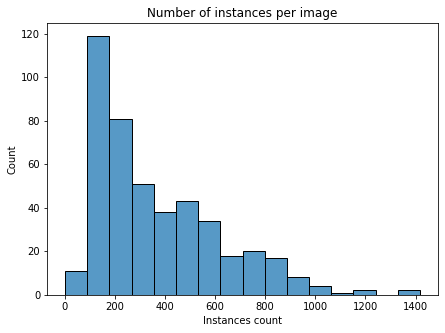

In [12]:
fig = plt.figure(figsize=(7, 5))

sns.histplot(x=ins_per_img.values)
plt.title('Number of instances per image')
plt.xlabel('Instances count')

plt.show()

Convert polygon to rle

In [13]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

def convert_polygon_to_rle(annot_polygon):
    rle = coco_mask.frPyObjects(annot_polygon, 520, 704)
    mask = coco_mask.decode(rle)
    rle = rle_encode(mask)
    
    return rle

def rle_decode_by_image_id(image_id, df):
    SHAPE = (520, 704)
    rows = df.loc[df['image_id'] == image_id]
    
    # Image shape
    mask = np.full(shape=[len(rows), np.prod(SHAPE)], fill_value=0, dtype=np.uint8)
    
    for idx, (_, row) in enumerate(rows.iterrows()):
        s = row['segmentation'].split()
        starts, lengths = [np.array(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            mask[idx, lo:hi] = True
        
    mask = mask.reshape([len(rows), *SHAPE])
    mask = np.moveaxis(mask, 0, 2)
    
    return mask

In [17]:
annot_rle = annotation_df['segmentation'].apply(convert_polygon_to_rle)

In [18]:
annotation_df['segmentation'] = annot_rle
annotation_df

,segmentation,area,iscrowd,image_id,bbox,category_id,id
1564018,89136 1 89837 5 90540 8 91244 9 91949 9 92653 ...,300.0471,0,1564017,"[427.25, 126.36, 18.899999999999977, 42.769999...",1,1564018
1564019,185410 2 186114 13 186132 7 186817 29 187520 3...,223.89695,0,1564017,"[253.26, 263.1, 38.79000000000002, 9.389999999...",1,1564019
1564020,183343 2 184044 5 184738 4 184747 7 185441 17 ...,129.8141,0,1564017,"[282.32, 260.36, 22.889999999999986, 14.610000...",1,1564020
1564021,165739 2 166442 3 167144 5 167847 7 168550 8 1...,333.7615,0,1564017,"[277.3, 234.48, 39.90999999999997, 20.14000000...",1,1564021
1564022,173 8 876 10 1580 10 2283 12 2988 11 3692 11 4...,234.7215,0,1564017,"[170.17, 0.0, 16.840000000000003, 30.9]",1,1564022
...,...,...,...,...,...,...,...
1434781,25415 7 26115 18 26817 23 27519 28 28222 32 28...,473.75765,0,1434614,"[58.24, 36.36, 60.690000000000005, 25.4]",1,1434781
1434782,20500 6 21203 8 21905 11 22609 11 23312 13 240...,306.22035,0,1434614,"[65.93, 28.92, 26.189999999999998, 38.09]",1,1434782
1434783,80509 4 81211 7 81914 9 82603 2 82617 10 83308...,378.59555,0,1434614,"[221.86, 113.37, 36.44999999999999, 41.28]",1,1434783
1434784,93177 6 93879 10 94581 14 95284 16 95986 20 96...,389.8525,0,1434614,"[235.03, 131.83, 47.619999999999976, 16.349999...",1,1434784


In [19]:
image_id = 1564017
anns = annotation_df.loc[annotation_df['image_id'] == 1564017, 'segmentation'].to_list()
#rles = [coco_mask.decode(coco_mask.frPyObjects(ann, 520, 704)) for ann in anns]
#mask = np.concatenate(rles, axis=-1)
mask = rle_decode_by_image_id(image_id, annotation_df)

assert len(anns) == mask.shape[-1]

In [20]:
img_file = image_df.loc[image_df['id'] == image_id, 'file_name'].to_list()[0]
img_file = os.path.join(SHSY5Y_LIVECELL_TRAIN_IMAGE_FOLDER, img_file)

img = tifffile.imread(img_file)

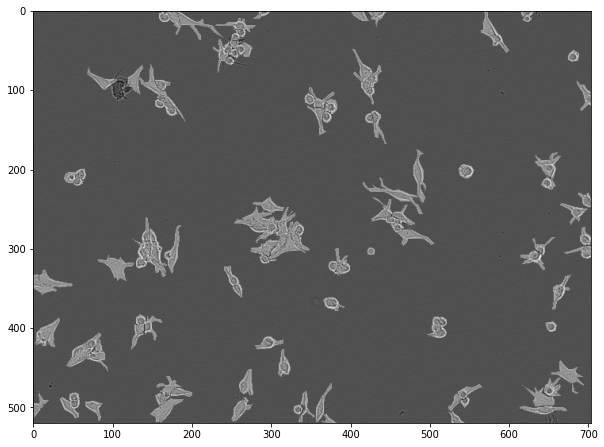

In [21]:
merged = cv2.addWeighted(img, 0.75, 
                             np.clip(np.sum(mask, -1).astype(img.dtype), 0, 1)*255, 0.25, 0.0,)

fig = plt.figure(figsize=(10, 10))
plt.imshow(merged, cmap='gray')

Save images to working directory

In [31]:
!mkdir ./images

In [32]:
for _, row in tqdm(image_df.iterrows()):
    img_path = os.path.join(SHSY5Y_LIVECELL_TRAIN_IMAGE_FOLDER, row['file_name'])
    
    # Read file
    img = tifffile.imread(img_path)
    
    # Save file
    des_path = os.path.join('images', row['original_filename'])
    skimage.io.imsave(des_path, img)

449it [01:11,  6.31it/s]


Create LiveCell DataFrame

In [33]:
image_df.head()

,url,file_name,height,width,original_filename,id
0,https://darwin.v7labs.com/api/images/37815/ori...,SHSY5Y_Phase_C10_2_00d04h00m_3.tif,520,704,SHSY5Y_Phase_C10_2_00d04h00m_3.png,1564017
1,https://darwin.v7labs.com/api/images/108474/or...,SHSY5Y_Phase_B10_1_03d12h00m_2.tif,520,704,SHSY5Y_Phase_B10_1_03d12h00m_2.png,1420519
2,https://darwin.v7labs.com/api/images/922455/or...,SHSY5Y_Phase_D10_1_00d00h00m_4.tif,520,704,SHSY5Y_Phase_D10_1_00d00h00m_4.png,1419396
3,https://darwin.v7labs.com/api/images/47611/ori...,SHSY5Y_Phase_B10_2_01d12h00m_1.tif,520,704,SHSY5Y_Phase_B10_2_01d12h00m_1.png,1498293
4,https://darwin.v7labs.com/api/images/47647/ori...,SHSY5Y_Phase_D10_1_02d08h00m_1.tif,520,704,SHSY5Y_Phase_D10_1_02d08h00m_1.png,1439054


In [34]:
annotation_df.head()

,segmentation,area,iscrowd,image_id,bbox,category_id,id
1564018,89136 1 89837 5 90540 8 91244 9 91949 9 92653 ...,300.0471,0,1564017,"[427.25, 126.36, 18.899999999999977, 42.769999...",1,1564018
1564019,185410 2 186114 13 186132 7 186817 29 187520 3...,223.89695,0,1564017,"[253.26, 263.1, 38.79000000000002, 9.389999999...",1,1564019
1564020,183343 2 184044 5 184738 4 184747 7 185441 17 ...,129.8141,0,1564017,"[282.32, 260.36, 22.889999999999986, 14.610000...",1,1564020
1564021,165739 2 166442 3 167144 5 167847 7 168550 8 1...,333.7615,0,1564017,"[277.3, 234.48, 39.90999999999997, 20.14000000...",1,1564021
1564022,173 8 876 10 1580 10 2283 12 2988 11 3692 11 4...,234.7215,0,1564017,"[170.17, 0.0, 16.840000000000003, 30.9]",1,1564022


In [35]:
image_dict = dict([(k, v) for k, v in image_df[['id', 'original_filename']].itertuples(index=False)])

In [36]:
img_file, annotation = [], []

start = time.time()

for row in tqdm(annotation_df.itertuples(index=False)):
    annotation.append(row.segmentation)
    img_file.append(image_dict[row.image_id])
    
end = time.time()

cell_type = ['shsy5y'] * len(img_file)

165397it [00:00, 232739.99it/s]


In [37]:
(end - start) / 60

0.011945180098215739

In [38]:
final_df = pd.DataFrame({'image_id': img_file, 'segmentation': annotation, 'cell_type': cell_type})
final_df.head()

,image_id,segmentation,cell_type
0,SHSY5Y_Phase_C10_2_00d04h00m_3.png,89136 1 89837 5 90540 8 91244 9 91949 9 92653 ...,shsy5y
1,SHSY5Y_Phase_C10_2_00d04h00m_3.png,185410 2 186114 13 186132 7 186817 29 187520 3...,shsy5y
2,SHSY5Y_Phase_C10_2_00d04h00m_3.png,183343 2 184044 5 184738 4 184747 7 185441 17 ...,shsy5y
3,SHSY5Y_Phase_C10_2_00d04h00m_3.png,165739 2 166442 3 167144 5 167847 7 168550 8 1...,shsy5y
4,SHSY5Y_Phase_C10_2_00d04h00m_3.png,173 8 876 10 1580 10 2283 12 2988 11 3692 11 4...,shsy5y


Plot sample

In [39]:
img_id = final_df.loc[0, 'image_id']
mask = rle_decode_by_image_id(img_id, final_df)

In [40]:
img = skimage.io.imread(os.path.join('./images', img_id))

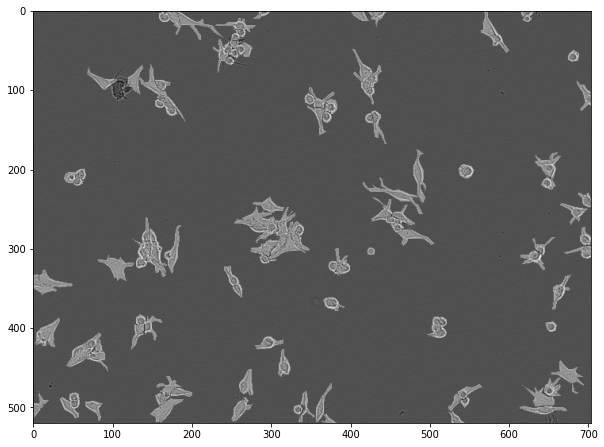

In [41]:
merged = cv2.addWeighted(img, 0.75, 
                             np.clip(np.sum(mask, -1).astype(img.dtype), 0, 1)*255, 0.25, 0.0,)

fig = plt.figure(figsize=(10, 10))
plt.imshow(merged, cmap='gray')

In [42]:
img_id = np.random.choice(final_df['image_id'], 1)[0]
mask = rle_decode_by_image_id(img_id, final_df)
img = skimage.io.imread(os.path.join('./images', img_id))

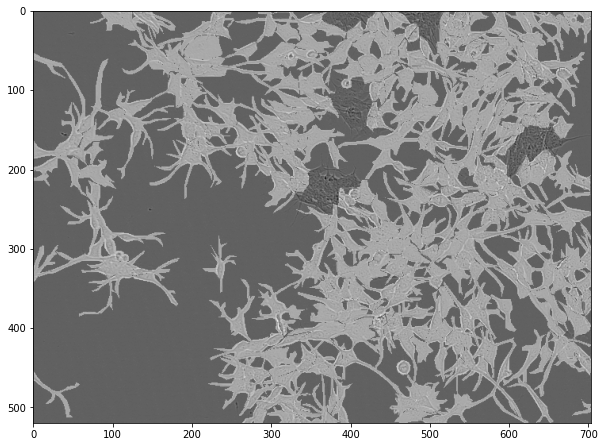

In [43]:
merged = cv2.addWeighted(img, 0.75, 
                             np.clip(np.sum(mask, -1).astype(img.dtype), 0, 1)*255, 0.25, 0.0,)

fig = plt.figure(figsize=(10, 10))
plt.imshow(merged, cmap='gray')